In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from tensorflow.keras.models import Model
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input, Add, Activation
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import auc, precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna.visualization as vis
import matplotlib.pyplot as plt

/Users/shivamsharma/anaconda3/envs/masters/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import optuna
from sklearn.metrics import f1_score

In [3]:
ratio_data = pd.read_csv("ratio.csv")

In [5]:
ratio_data.head()

index                 grp  Age  Gender  \
0  1002P  normal_colonoscopy   60    Male   
1   100N            negative   64  Female   
2   100P              cancer   64    Male   
3   101N            negative   60  Female   
4   101P  normal_colonoscopy   67  Female   

   D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae  \
0                                            0.00029                                                       
1                                            0.00000                                                       
2                                            0.00000                                                       
3                                            0.00000                                                       
4                                            0.00000                                                       

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Actinomycetales.D_4__Actinomycetaceae  \
0                                           0.000168                                                  
1                                           0.000259                                                  
2                                           0.000000                                                  
3                                           0.000148                                                  
4                                           0.000131                                                  

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Bifidobacteriales.D_4__Bifidobacteriaceae  \
0                                           0.002133                                                      
1                                           0.019011                                                      
2                                           0.006305                                                      
3                                           0.021590                                                      
4                                           0.072117                                                      

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Corynebacteriales.D_4__Corynebacteriaceae  \
0                                           0.000000                                                      
1                                           0.000016                                                      
2                                           0.000000                                                      
3                                           0.000000                                                      
4                                           0.000000                                                      

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Micrococcales.D_4__Micrococcaceae  \
0                                                0.0                                              
1                                                0.0                                              
2                                                0.0                                              
3                                                0.0                                              
4                                                0.0                                              

   D_0__Bacteria.D_1__Actinobacteria.D_2__Coriobacteriia.D_3__Coriobacteriales.D_4__Coriobacteriaceae  \
0                                           0.010785                                                    
1                                           0.009317                                                    
2                                           0.001446                                                    
3                                           0.010218                                                    
4                                           0.036632      

In [118]:
ratio_data['grp'].value_counts()

grp
negative              491
cancer                430
other                 366
normal_colonoscopy    300
low                   242
intermediate          232
high                  191
Name: count, dtype: int64

In [6]:

def filter_data(groups, target_positive):
    filtered = ratio_data[ratio_data['grp'].isin(groups)].copy()
    filtered.loc[:, 'target'] = filtered['grp'].apply(lambda x: 1 if x == target_positive else 0)
    return filtered

In [7]:
# Function for data preparation for train and test

def prepare_data(filtered):
    train_data, test_data = train_test_split(filtered, test_size=0.2, random_state=123)
    
    feature_names_list = train_data.drop(columns=['index', 'grp', 'target']).columns.tolist()

    train_x = train_data.drop(columns=['index', 'grp', 'target'])
    train_y = train_data['target']
    test_x = test_data.drop(columns=['index', 'grp', 'target'])
    test_y = test_data['target']

    # Encode categorical features 
    for col in train_x.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        train_x[col] = le.fit_transform(train_x[col])
        test_x[col] = le.transform(test_x[col])

    return train_x, train_y, test_x, test_y, feature_names_list

In [119]:
cancer_vs_negative = filter_data(['cancer', 'negative'], 'cancer')

train_x, train_y, test_x, test_y, feature_names_list = prepare_data(cancer_vs_negative)

In [120]:
cancer_vs_negative.head()

index       grp  Age  Gender  \
1  100N  negative   64  Female   
2  100P    cancer   64    Male   
3  101N  negative   60  Female   
5  102N  negative   62    Male   
6  103N  negative   62    Male   

   D_0__Archaea.D_1__Euryarchaeota.D_2__Methanobacteria.D_3__Methanobacteriales.D_4__Methanobacteriaceae  \
1                                           0.000000                                                       
2                                           0.000000                                                       
3                                           0.000000                                                       
5                                           0.000000                                                       
6                                           0.000267                                                       

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Actinomycetales.D_4__Actinomycetaceae  \
1                                           0.000259                                                  
2                                           0.000000                                                  
3                                           0.000148                                                  
5                                           0.000342                                                  
6                                           0.000000                                                  

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Bifidobacteriales.D_4__Bifidobacteriaceae  \
1                                           0.019011                                                      
2                                           0.006305                                                      
3                                           0.021590                                                      
5                                           0.055914                                                      
6                                           0.017609                                                      

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Corynebacteriales.D_4__Corynebacteriaceae  \
1                                           0.000016                                                      
2                                           0.000000                                                      
3                                           0.000000                                                      
5                                           0.000000                                                      
6                                           0.000000                                                      

   D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Micrococcales.D_4__Micrococcaceae  \
1                                           0.000000                                              
2                                           0.000000                                              
3                                           0.000000                                              
5                                           0.000119                                              
6                                           0.000000                                              

   D_0__Bacteria.D_1__Actinobacteria.D_2__Coriobacteriia.D_3__Coriobacteriales.D_4__Coriobacteriaceae  \
1                                           0.009317                                                    
2                                           0.001446                                                    
3                                           0.010218                                                    
5                                           0.019014                                                    
6                                           0.009398                                                    

   ...  \
1  ... 

In [10]:
#Function for evaluating the model

def evaluate_model(y_true, y_pred, y_pred_prob, title='Model Evaluation'):
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC): {title}')
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {title}')
    plt.show()

    f1 = f1_score(y_true, y_pred)
    print(f'F1-Score: {f1}')

In [11]:
# Function for cross-validation and CV AUC plot.
def CV_ROC(model, X, y, n_splits=10):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(10, 8))
    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_val_pred_prob = model.predict_proba(X.iloc[val_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y.iloc[val_idx], y_val_pred_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-Validation ROC')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Cross-validation AUC Scores: {aucs}")
    print(f"Mean Cross-validation AUC: {mean_auc:.4f}")

Random Forest Model

In [12]:
rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=400, random_state=42)

In [19]:
# Predictions
#test_y_pred_rf = rf.predict(test_x)
test_y_pred_prob_rf = rf.predict_proba(test_x)[:, 1]
test_y_pred_rf = (test_y_pred_prob_rf > 0.5).astype(int)

Evaluation on Test Data
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        93
           1       0.81      0.68      0.74        92

    accuracy                           0.76       185
   macro avg       0.77      0.76      0.76       185
weighted avg       0.77      0.76      0.76       185



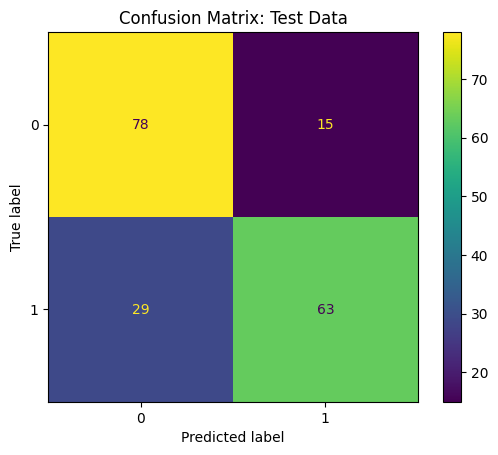

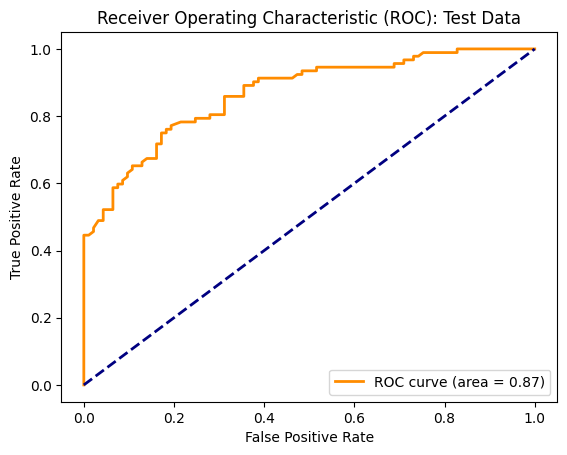

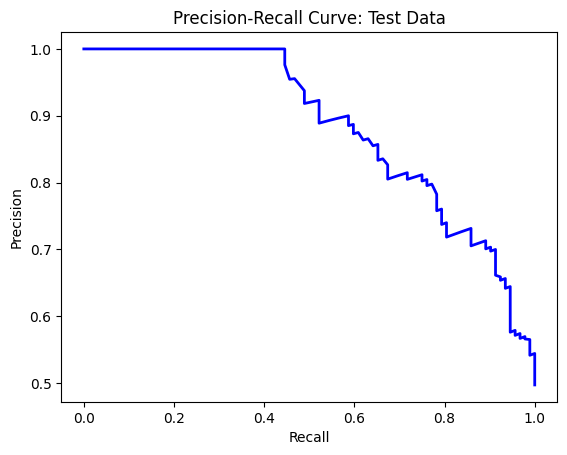

F1-Score: 0.7411764705882353


In [20]:
# Evaluate the initial model on test data
print("Evaluation on Test Data")
evaluate_model(test_y, test_y_pred_rf, test_y_pred_prob_rf, title='Test Data')

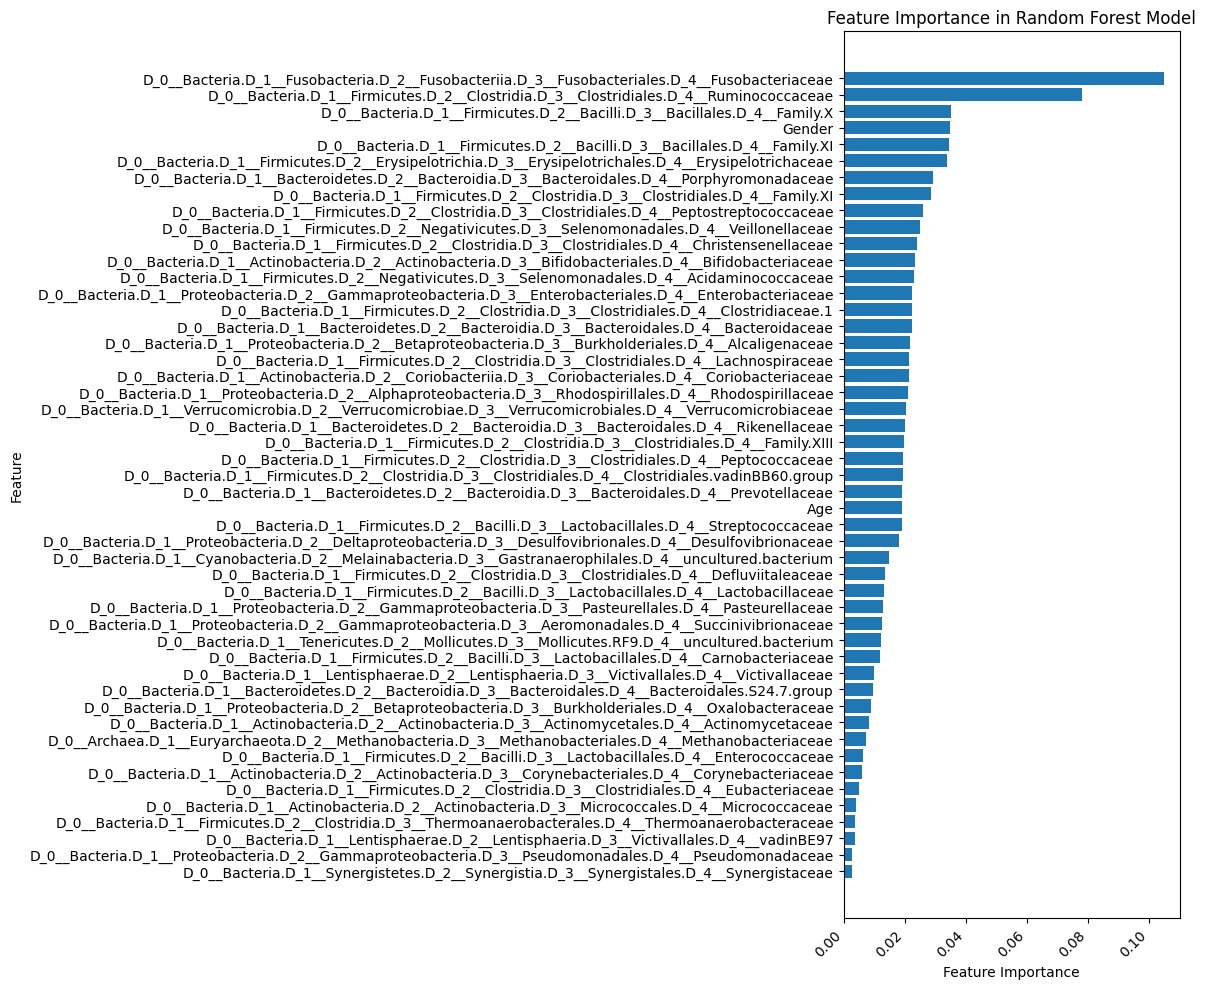

In [21]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Hyperparameter Tuning of Random Forest

In [36]:
def objective_rf(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_categorical('max_features', [ 'sqrt', 'log2', None])
    threshold = trial.suggest_float('threshold', 0.1, 0.9)

    # Create the model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    rf.fit(train_x, train_y)
    
    # Predict and calculate accuracy
    y_pred_prob = rf.predict_proba(test_x)[:, 1]
    y_pred = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, y_pred)
    return accuracy

In [37]:
# Optimize hyperparameters using Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=70)

[I 2024-08-07 17:14:48,615] A new study created in memory with name: no-name-e5552e75-5262-4957-a335-bd0d53d77929
[I 2024-08-07 17:14:49,045] Trial 0 finished with value: 0.6432432432432432 and parameters: {'n_estimators': 124, 'max_depth': 19, 'min_samples_split': 87, 'min_samples_leaf': 38, 'max_features': None, 'threshold': 0.8343406029901311}. Best is trial 0 with value: 0.6432432432432432.
[I 2024-08-07 17:14:49,494] Trial 1 finished with value: 0.6972972972972973 and parameters: {'n_estimators': 155, 'max_depth': 29, 'min_samples_split': 84, 'min_samples_leaf': 49, 'max_features': None, 'threshold': 0.5078403411491005}. Best is trial 1 with value: 0.6972972972972973.
[I 2024-08-07 17:14:49,764] Trial 2 finished with value: 0.5027027027027027 and parameters: {'n_estimators': 316, 'max_depth': 29, 'min_samples_split': 46, 'min_samples_leaf': 18, 'max_features': 'log2', 'threshold': 0.14563433384414692}. Best is trial 1 with value: 0.6972972972972973.
[I 2024-08-07 17:14:49,823] Tri

In [38]:
# Best hyperparameters
best_params_rf = study_rf.best_params
print("Best hyperparameters: ", best_params_rf)

Best hyperparameters:  {'n_estimators': 281, 'max_depth': 8, 'min_samples_split': 39, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'threshold': 0.43922065842380276}


In [39]:
# Train the tuned Random Forest model
rf_tuned = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_tuned.fit(train_x, train_y)

# Predictions
#test_y_pred_tunedrf = rf_tuned.predict(test_x)
test_y_pred_prob_tunedrf = rf_tuned.predict_proba(test_x)[:, 1]
test_y_pred_tunedrf = (test_y_pred_prob_tunedrf > best_params_rf['threshold']).astype(int)

Evaluation on Test Data (Tuned)
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        93
           1       0.77      0.78      0.78        92

    accuracy                           0.78       185
   macro avg       0.78      0.78      0.78       185
weighted avg       0.78      0.78      0.78       185



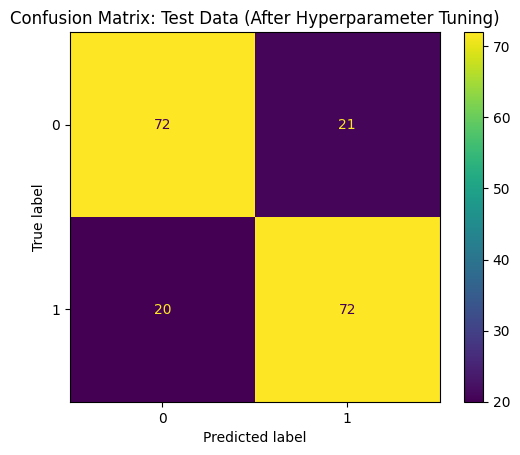

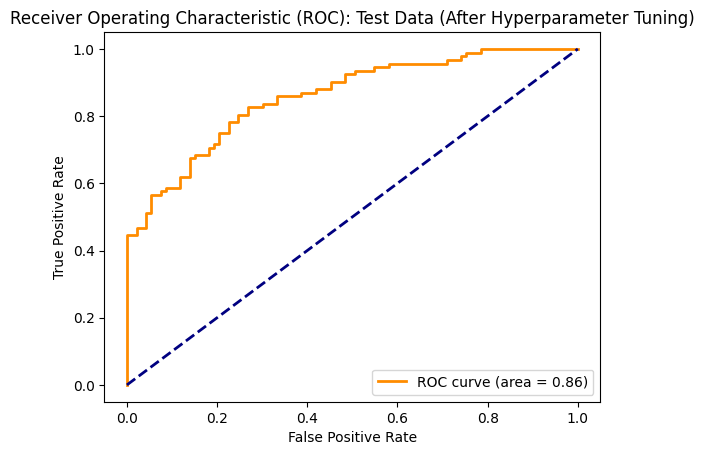

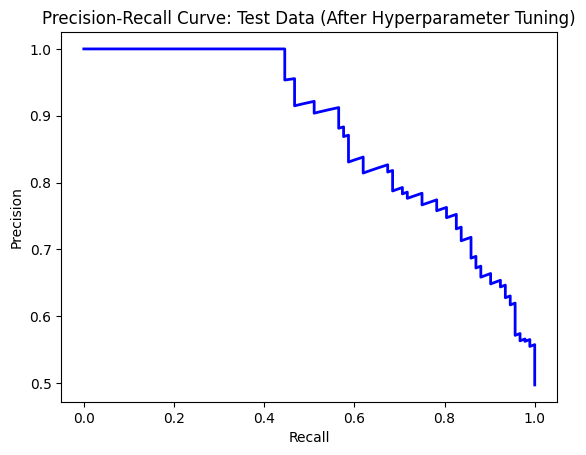

F1-Score: 0.7783783783783784


In [40]:
# Evaluate the tuned model on test data
print("Evaluation on Test Data (Tuned)")
evaluate_model(test_y, test_y_pred_tunedrf, test_y_pred_prob_tunedrf, title='Test Data (After Hyperparameter Tuning)')

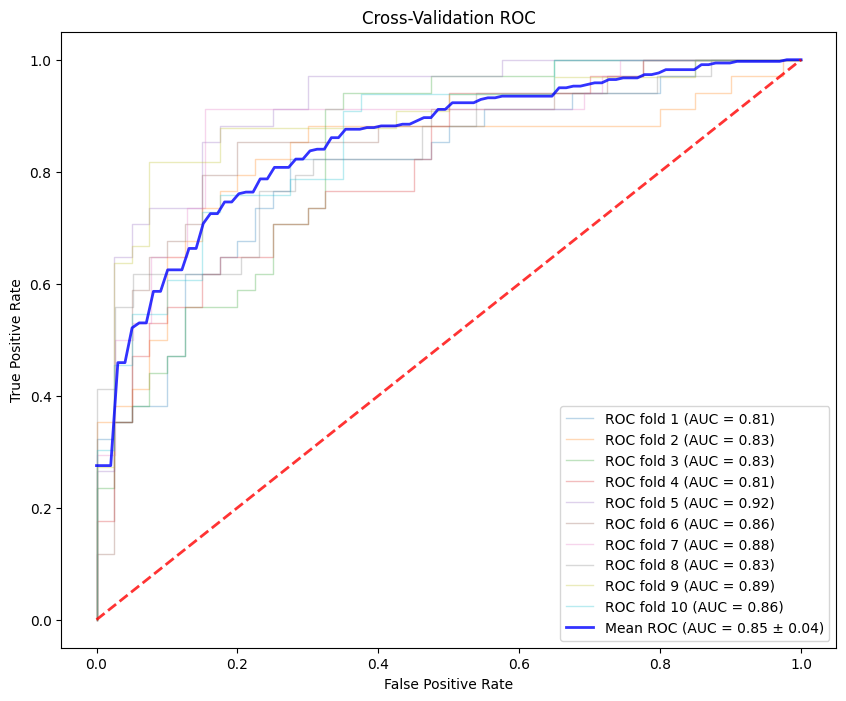

Cross-validation AUC Scores: [0.8095588235294117, 0.8257352941176469, 0.8330882352941177, 0.8080882352941177, 0.9205882352941176, 0.8573529411764705, 0.8823529411764706, 0.834841628959276, 0.8939393939393939, 0.8606060606060606]
Mean Cross-validation AUC: 0.8529


In [41]:
CV_ROC(rf_tuned, train_x, train_y)

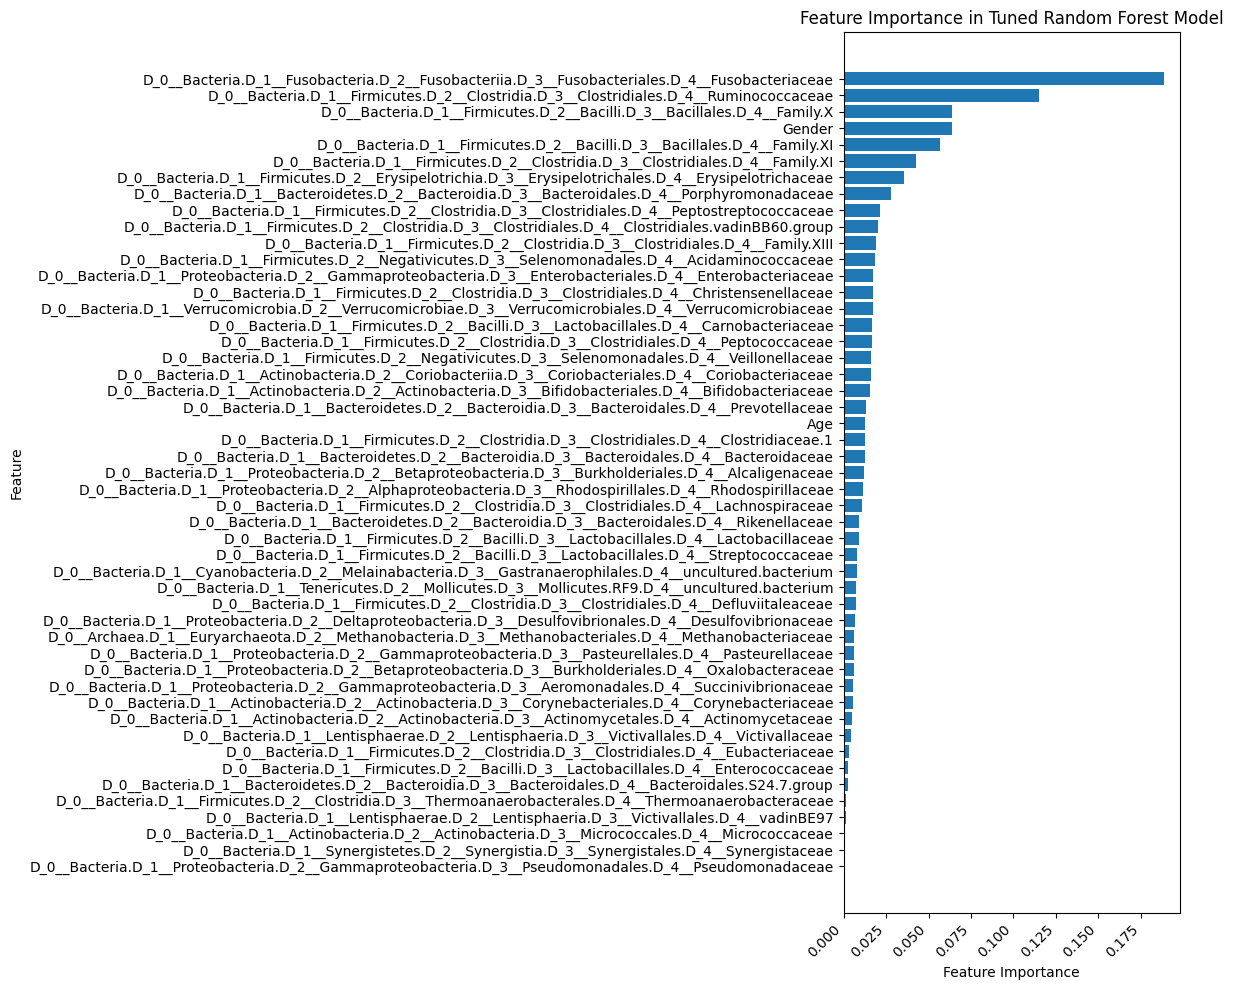

In [167]:
# Get feature importances
importances = rf_tuned.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Tuned Random Forest Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [170]:
pd.set_option('display.max_colwidth', None)
feature_importances_df.head(10)

Feature  \
35         D_0__Bacteria.D_1__Fusobacteria.D_2__Fusobacteriia.D_3__Fusobacteriales.D_4__Fusobacteriaceae   
30                 D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Ruminococcaceae   
14                              D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Bacillales.D_4__Family.X   
1                                                                                                 Gender   
15                             D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Bacillales.D_4__Family.XI   
25                       D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Family.XI   
32  D_0__Bacteria.D_1__Firmicutes.D_2__Erysipelotrichia.D_3__Erysipelotrichales.D_4__Erysipelotrichaceae   
10          D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Porphyromonadaceae   
29           D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Peptostreptococcaceae   
22   D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Clostridiales.vadinBB60.group   

    Importance  
35    0.188553  
30    0.114734  
14    0.063971  
1     0.063895  
15    0.056737  
25    0.042927  
32    0.035520  
10    0.028065  
29    0.021252  
22    0.020071

In [123]:
def proximity_matrix(model, X):
    terminals = model.apply(X)
    n_samples = X.shape[0]
    proximity = np.zeros((n_samples, n_samples))

    for tree_idx in range(terminals.shape[1]):
        for i in range(n_samples):
            for j in range(n_samples):
                if terminals[i, tree_idx] == terminals[j, tree_idx]:
                    proximity[i, j] += 1

    proximity /= terminals.shape[1]  # Normalize by number of trees
    return proximity



In [165]:
proximity = proximity_matrix(rf_tuned, train_x)

KeyboardInterrupt: 

In [125]:
from sklearn.manifold import MDS

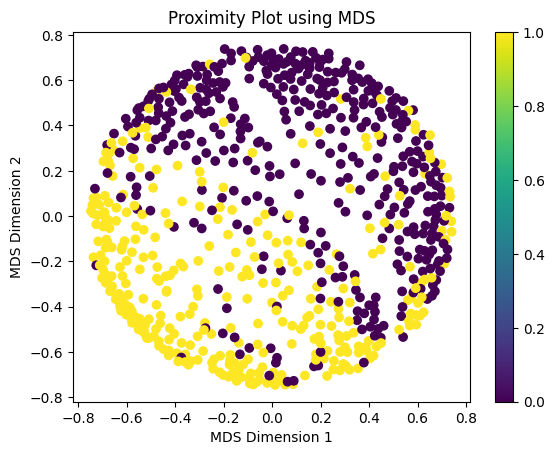

In [127]:
# Use MDS to reduce dimensions
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(1 - proximity)

# Plot the results
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], c=train_y, cmap='viridis')
plt.colorbar()
plt.title("Proximity Plot using MDS")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

TRAINING LIGHTGBM

In [47]:
# Initial training of the model
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(train_x, train_y)


# Predict and evaluate on test data
#y_test_pred_lgb = model_lgb.predict(test_x)
y_test_pred_prob_lgb = model_lgb.predict_proba(test_x)[:, 1]
y_test_pred_lgb = (y_test_pred_prob_lgb > 0.5).astype(int)


[LightGBM] [Info] Number of positive: 338, number of negative: 398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7392
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459239 -> initscore=-0.163406
[LightGBM] [Info] Start training from score -0.163406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

              precision    recall  f1-score   support

           0       0.73      0.71      0.72        93
           1       0.71      0.73      0.72        92

    accuracy                           0.72       185
   macro avg       0.72      0.72      0.72       185
weighted avg       0.72      0.72      0.72       185



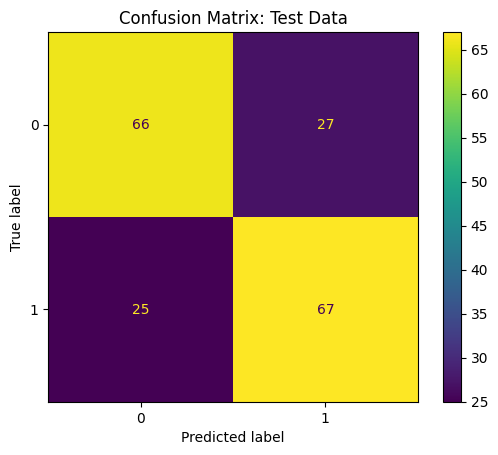

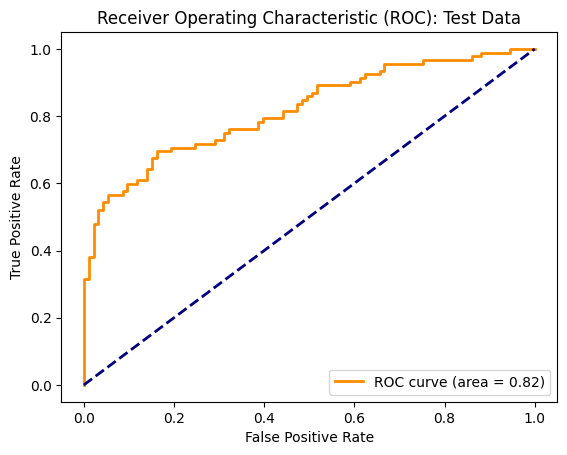

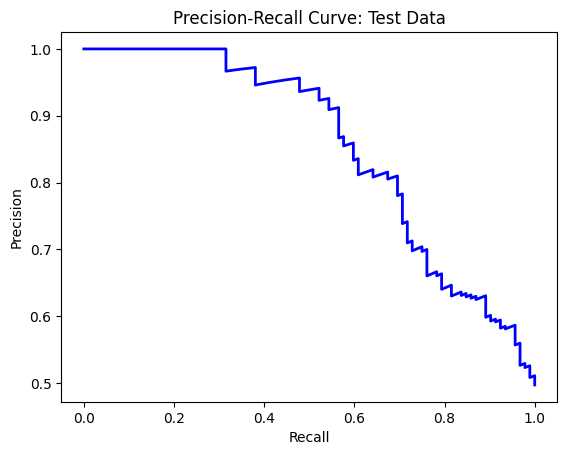

F1-Score: 0.7204301075268817


In [48]:
evaluate_model(test_y, y_test_pred_lgb, y_test_pred_prob_lgb, title='Test Data')

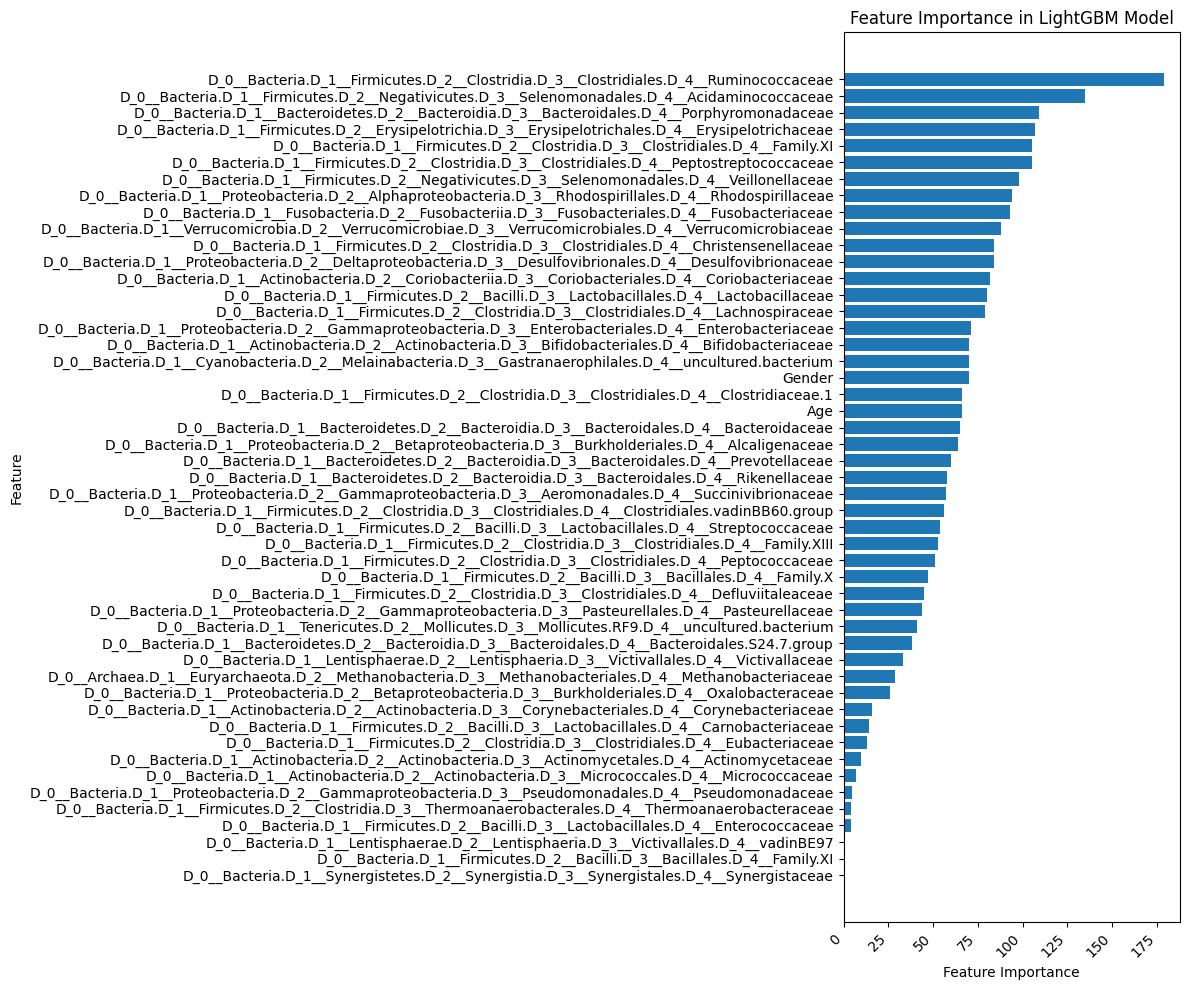

In [49]:
# Get feature importances
importances = model_lgb.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in LightGBM Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Hyperparameter Tuning of LightGBM

In [51]:
def objective_lgb(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
    }
    threshold = trial.suggest_float('threshold', 0.1, 0.9)

    model = lgb.LGBMClassifier(**param, n_estimators=1000, early_stopping_rounds=50)
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], eval_metric='logloss')

    y_pred_prob = model.predict_proba(test_x)[:, 1]
    y_pred = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, y_pred)
    return accuracy

In [52]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50)

[I 2024-08-07 17:23:43,616] A new study created in memory with name: no-name-ed10d9f8-3caa-4f36-9a41-a1ead03dac4b
[I 2024-08-07 17:23:43,803] Trial 0 finished with value: 0.7189189189189189 and parameters: {'learning_rate': 0.014612366488254366, 'num_leaves': 184, 'max_depth': 29, 'min_data_in_leaf': 84, 'feature_fraction': 0.6237687496697939, 'bagging_fraction': 0.8364393770661902, 'bagging_freq': 7, 'lambda_l1': 0.00012958242780517794, 'lambda_l2': 0.00013822960890077856, 'threshold': 0.5812608167813503}. Best is trial 0 with value: 0.7189189189189189.
[I 2024-08-07 17:23:43,995] Trial 1 finished with value: 0.745945945945946 and parameters: {'learning_rate': 0.0153240550496395, 'num_leaves': 37, 'max_depth': 30, 'min_data_in_leaf': 77, 'feature_fraction': 0.5071570536549438, 'bagging_fraction': 0.8361256097407952, 'bagging_freq': 7, 'lambda_l1': 0.0004936678514722648, 'lambda_l2': 0.5467606069008153, 'threshold': 0.4520824112072169}. Best is trial 1 with value: 0.745945945945946.
[I

In [53]:
# Get the best hyperparameters
best_params_lgb = study_lgb.best_params
print("Best hyperparameters for LightGBM: ", best_params_lgb)

Best hyperparameters for LightGBM:  {'learning_rate': 0.02622095648651683, 'num_leaves': 200, 'max_depth': 50, 'min_data_in_leaf': 40, 'feature_fraction': 0.8656735134793141, 'bagging_fraction': 0.5346813577961307, 'bagging_freq': 7, 'lambda_l1': 1.3608422295315864e-05, 'lambda_l2': 0.0022838633454445078, 'threshold': 0.5519175959483338}


In [54]:
# Train the LightGBM model with best hyperparameters
model_lgb_tuned = lgb.LGBMClassifier(**best_params_lgb, n_estimators=1000)
model_lgb_tuned.fit(train_x, train_y, eval_set=[(test_x, test_y)], eval_metric='binary_logloss')

LGBMClassifier(bagging_fraction=0.5346813577961307, bagging_freq=7,
               feature_fraction=0.8656735134793141,
               lambda_l1=1.3608422295315864e-05,
               lambda_l2=0.0022838633454445078,
               learning_rate=0.02622095648651683, max_depth=50,
               min_data_in_leaf=40, n_estimators=1000, num_leaves=200,
               threshold=0.5519175959483338)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78        93
           1       0.79      0.73      0.76        92

    accuracy                           0.77       185
   macro avg       0.77      0.77      0.77       185
weighted avg       0.77      0.77      0.77       185



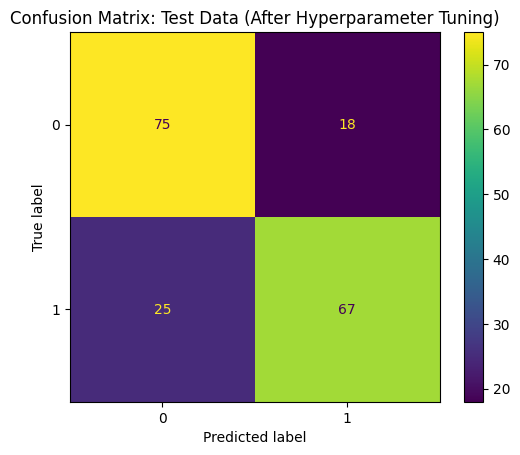

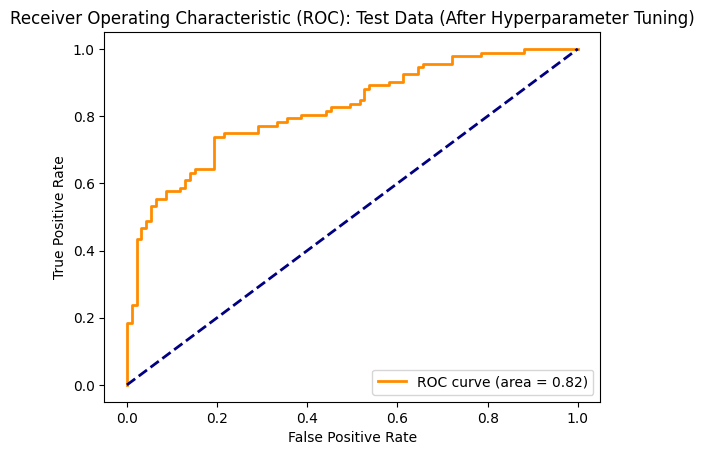

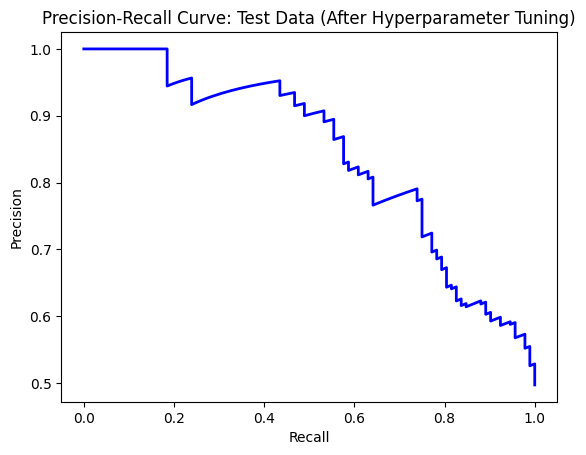

F1-Score: 0.7570621468926554


In [55]:
# Predict and evaluate on test data
#y_test_pred_tunedlgb = model_lgb_tuned.predict(test_x)
y_test_pred_prob_tunedlgb = model_lgb_tuned.predict_proba(test_x)[:, 1]
y_test_pred_tunedlgb = (y_test_pred_prob_tunedlgb > best_params_lgb['threshold']).astype(int)

# Test evaluation with best model
evaluate_model(test_y, y_test_pred_tunedlgb, y_test_pred_prob_tunedlgb, title = "Test Data (After Hyperparameter Tuning)")

In [56]:
# Perform cross-validation on the tuned model
cv_scores_tunedlgb = cross_val_score(model_lgb_tuned, train_x, train_y, cv=10, scoring='accuracy')
print("Cross-Validation Accuracy Scores (Tuned): ", cv_scores_tunedlgb)
print("Mean Cross-Validation Accuracy (Tuned): ", cv_scores_tunedlgb.mean())

Cross-Validation Accuracy Scores (Tuned):  [0.87837838 0.72972973 0.62162162 0.83783784 0.71621622 0.7972973
 0.73972603 0.65753425 0.76712329 0.76712329]
Mean Cross-Validation Accuracy (Tuned):  0.751258793039615


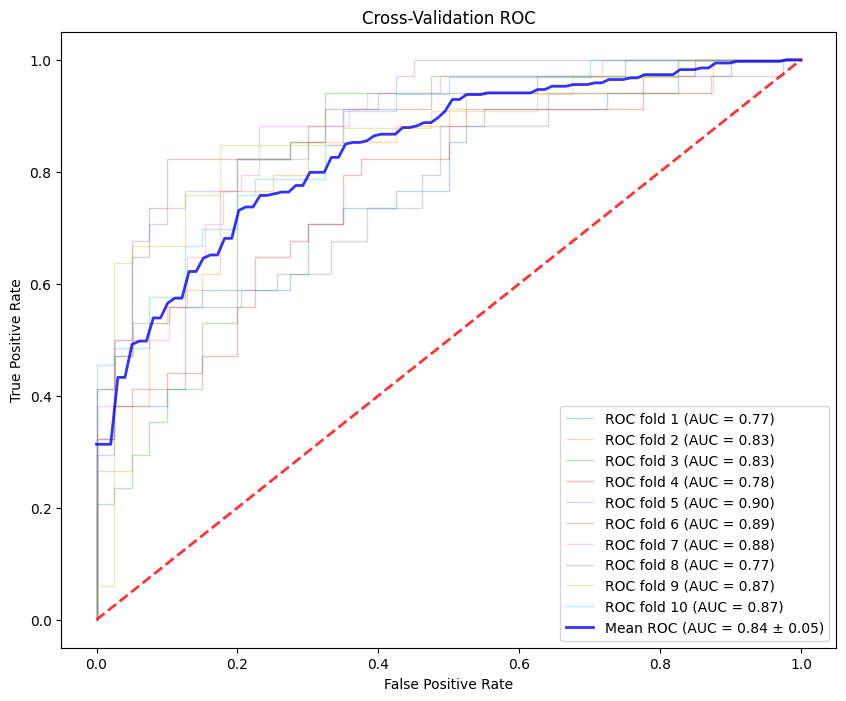

Cross-validation AUC Scores: [0.7676470588235295, 0.8272058823529411, 0.8345588235294117, 0.7779411764705882, 0.899264705882353, 0.8933823529411765, 0.8763197586726998, 0.7745098039215688, 0.8674242424242424, 0.8674242424242424]
Mean Cross-validation AUC: 0.8389


In [57]:
CV_ROC(model_lgb_tuned, train_x, train_y)

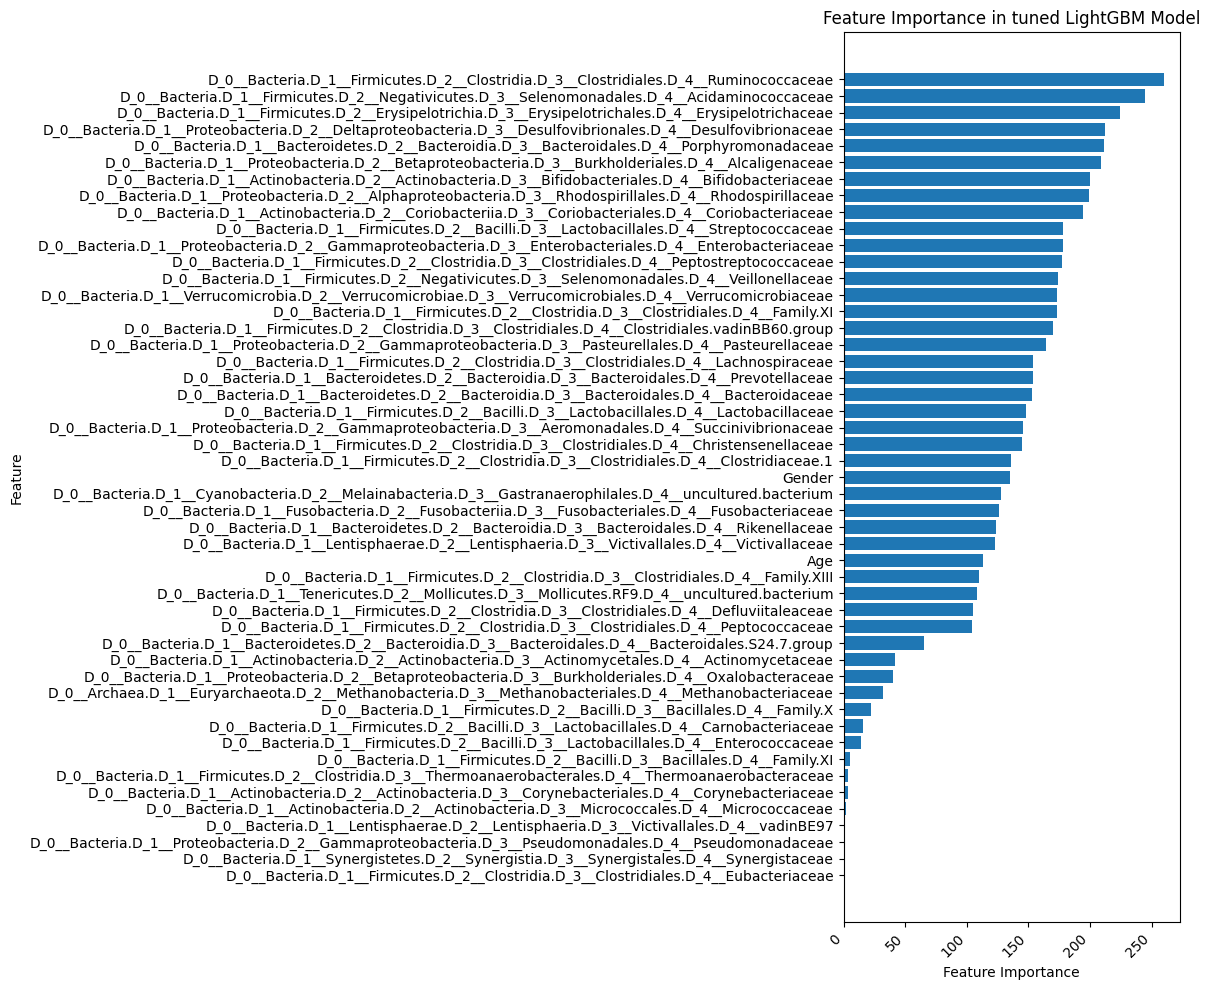

In [174]:
# Get feature importances
importances = model_lgb_tuned.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in tuned LightGBM Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [175]:
feature_importances_df.head(10)

Feature  \
30                        D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Ruminococcaceae   
33                D_0__Bacteria.D_1__Firmicutes.D_2__Negativicutes.D_3__Selenomonadales.D_4__Acidaminococcaceae   
32         D_0__Bacteria.D_1__Firmicutes.D_2__Erysipelotrichia.D_3__Erysipelotrichales.D_4__Erysipelotrichaceae   
41  D_0__Bacteria.D_1__Proteobacteria.D_2__Deltaproteobacteria.D_3__Desulfovibrionales.D_4__Desulfovibrionaceae   
10                 D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Porphyromonadaceae   
39           D_0__Bacteria.D_1__Proteobacteria.D_2__Betaproteobacteria.D_3__Burkholderiales.D_4__Alcaligenaceae   
4          D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Bifidobacteriales.D_4__Bifidobacteriaceae   
38      D_0__Bacteria.D_1__Proteobacteria.D_2__Alphaproteobacteria.D_3__Rhodospirillales.D_4__Rhodospirillaceae   
7            D_0__Bacteria.D_1__Actinobacteria.D_2__Coriobacteriia.D_3__Coriobacteriales.D_4__Coriobacteriaceae   
19                        D_0__Bacteria.D_1__Firmicutes.D_2__Bacilli.D_3__Lactobacillales.D_4__Streptococcaceae   

    Importance  
30         260  
33         245  
32         224  
41         212  
10         211  
39         209  
4          200  
38         199  
7          194  
19         178

Training SVM

In [59]:
from sklearn.svm import SVC

In [60]:
svm = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm.fit(train_x, train_y)


SVC(probability=True, random_state=42)

In [75]:
test_y_pred_prob_svm = svm.predict_proba(test_x)[:, 1]
test_y_pred_svm = (test_y_pred_prob_svm > 0.43).astype(int) #Changed it because the probabilities were really close which was leading to 0.01 recall for Cancer Label.

              precision    recall  f1-score   support

           0       0.75      0.13      0.22        93
           1       0.52      0.96      0.67        92

    accuracy                           0.54       185
   macro avg       0.64      0.54      0.45       185
weighted avg       0.64      0.54      0.45       185



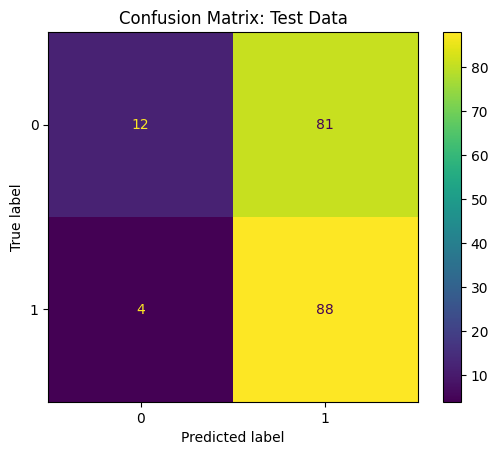

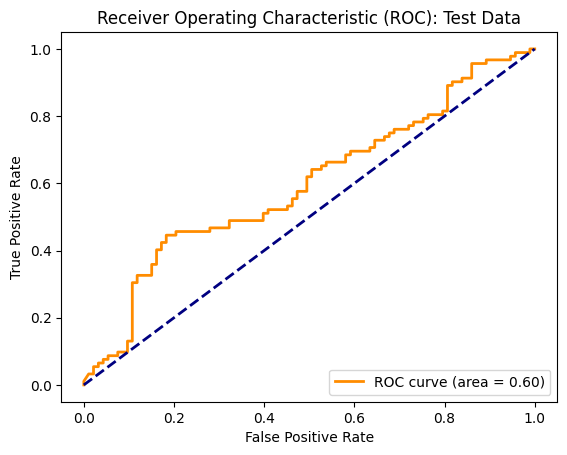

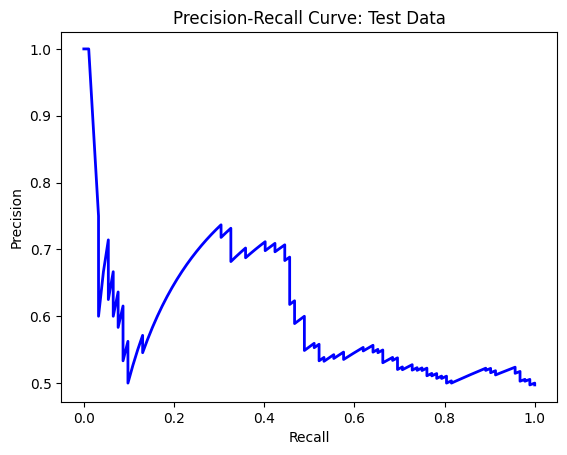

F1-Score: 0.6743295019157088


In [77]:
evaluate_model(test_y, test_y_pred_svm, test_y_pred_prob_svm, title = "Test Data")

In [78]:
# Function to tune hyperparameters using Optuna
def objective_svm(trial):
    # Suggest values for hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    degree = trial.suggest_int('degree', 2, 5)
    coef0 = trial.suggest_uniform('coef0', 0.0, 1.0)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    threshold = trial.suggest_float('threshold', 0.1, 0.9)
    
    # Create and fit SVM model
    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        degree=degree if kernel == 'poly' else 3,  # degree is used only in 'poly' kernel
        coef0=coef0 if kernel in ['poly', 'sigmoid'] else 0.0,  # coef0 is used in 'poly' and 'sigmoid' kernels
        shrinking=shrinking,
        probability=True,
        random_state=42
    )
    model.fit(train_x, train_y)
    
    # Make predictions and calculate accuracy
    y_pred_prob = model.predict_proba(test_x)[:, 1]
    y_pred = (y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, y_pred)
    return accuracy

In [79]:
# Optimize hyperparameters using Optuna
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=50)

[I 2024-08-07 17:34:58,946] A new study created in memory with name: no-name-d537e962-4cd1-4ffc-9f49-c6e6f4b61a09
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_69436/3823566310.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_69436/3823566310.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_69436/3823566310.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/op

In [80]:
best_params_svm = study_svm.best_params
best_params_svm

{'kernel': 'linear',
 'C': 32.34631288939771,
 'gamma': 0.0013874574898894705,
 'degree': 4,
 'coef0': 0.632578110698578,
 'shrinking': False,
 'threshold': 0.39432502143859577}

In [81]:
del best_params_svm['threshold']

In [82]:
# Get the best parameters and evaluate the model

svm_tuned = SVC(**best_params_svm, probability=True, random_state=42)
svm_tuned.fit(train_x, train_y)

# Evaluate the tuned model
test_y_pred_prob_svm_tuned = svm_tuned.predict_proba(test_x)[:, 1]
test_y_pred_svm_tuned = (test_y_pred_prob_svm_tuned > 0.39432502143859577).astype(int)


              precision    recall  f1-score   support

           0       0.76      0.62      0.69        93
           1       0.68      0.80      0.74        92

    accuracy                           0.71       185
   macro avg       0.72      0.71      0.71       185
weighted avg       0.72      0.71      0.71       185



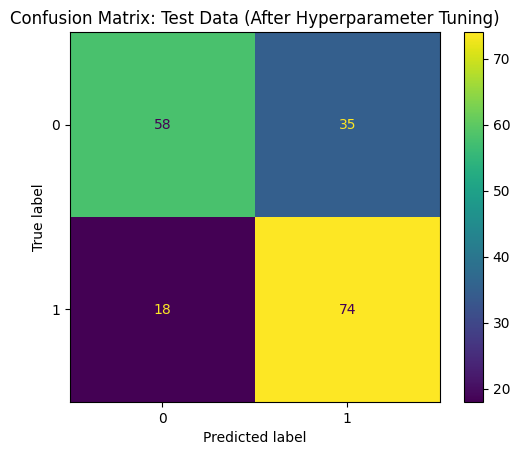

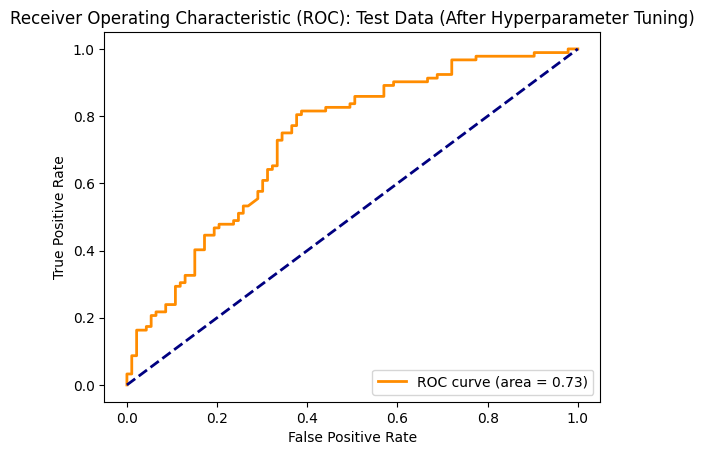

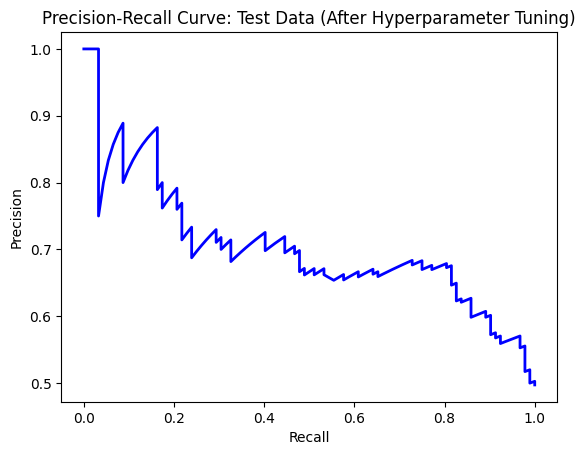

F1-Score: 0.736318407960199


In [83]:
evaluate_model(test_y, test_y_pred_svm_tuned, test_y_pred_prob_svm_tuned, title = "Test Data (After Hyperparameter Tuning)")

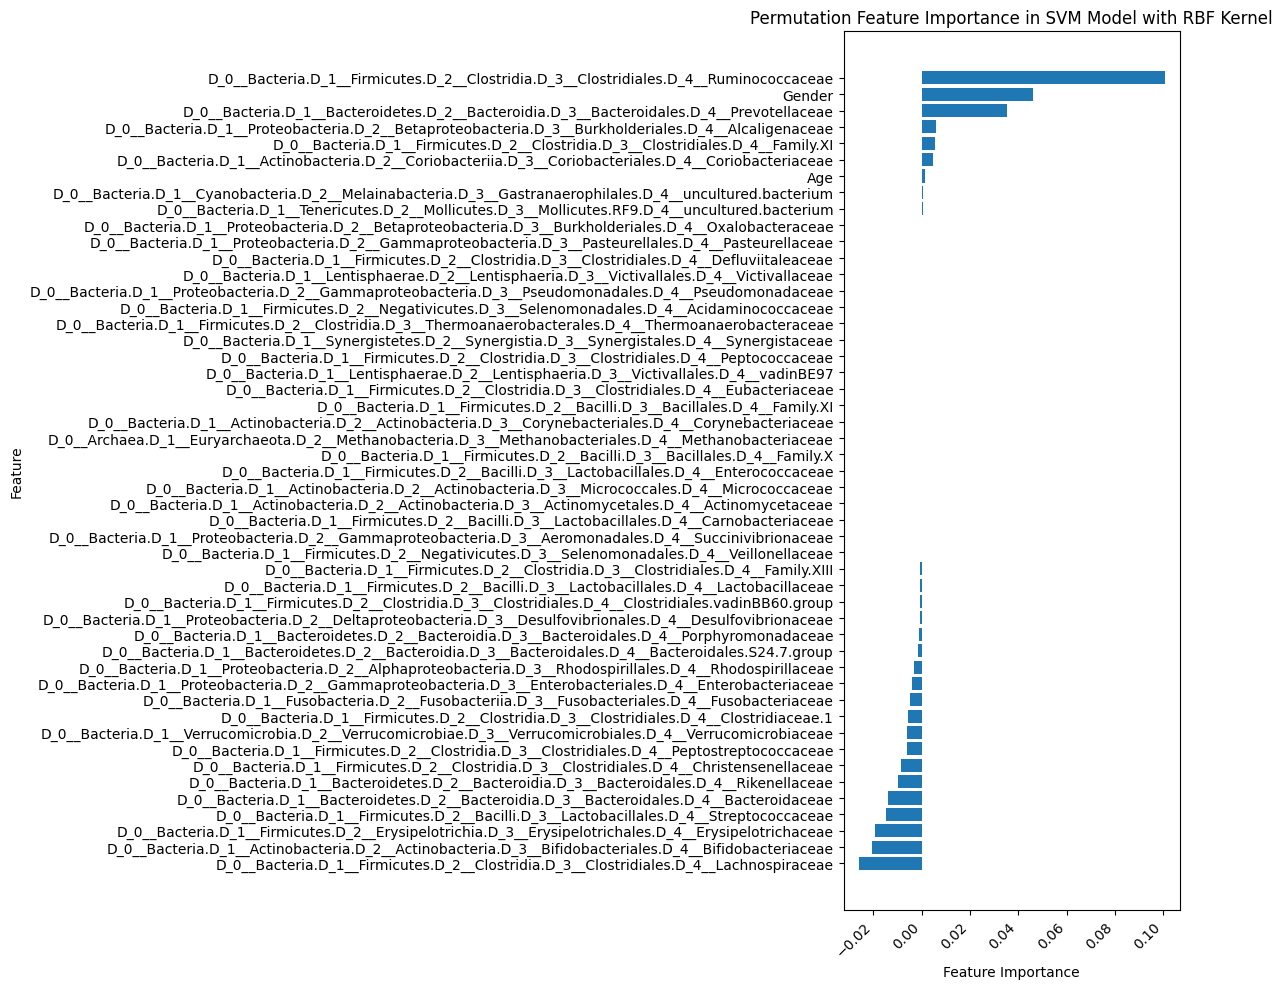

In [84]:
from sklearn.inspection import permutation_importance
# Compute permutation feature importance
result = permutation_importance(svm_tuned, test_x, test_y, n_repeats=10, random_state=42)

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': result.importances_mean
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance in SVM Model with RBF Kernel')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

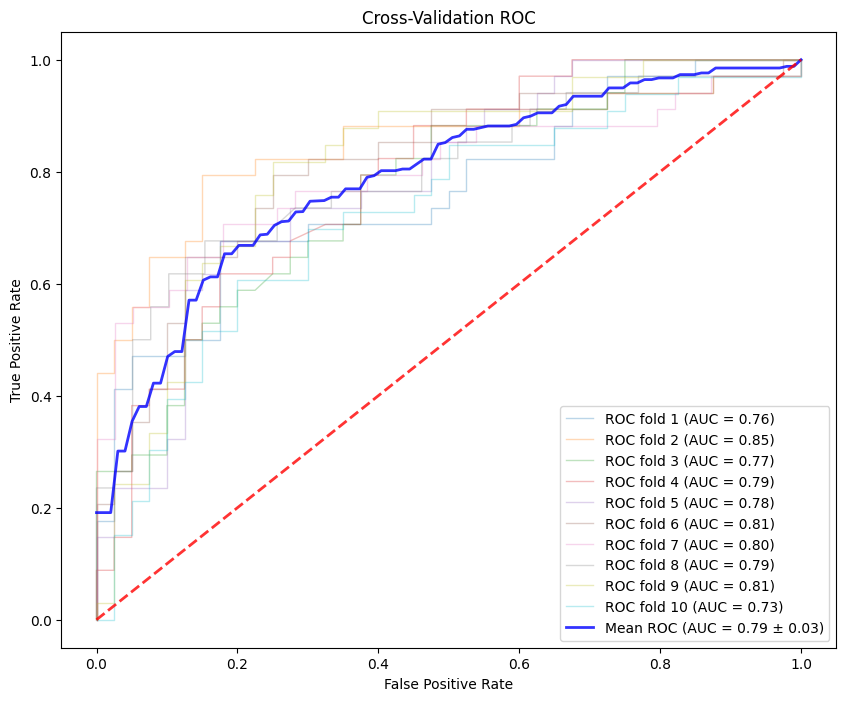

Cross-validation AUC Scores: [0.7625, 0.8463235294117646, 0.7680147058823529, 0.788235294117647, 0.7830882352941176, 0.8088235294117647, 0.7986425339366515, 0.7929864253393666, 0.8136363636363636, 0.7257575757575758]
Mean Cross-validation AUC: 0.7891


In [85]:
CV_ROC(svm_tuned, train_x, train_y)

Logistic Regression with Regularisation

In [86]:
logistic_model = LogisticRegression(random_state=42, max_iter=10000, C=1.0, penalty='l2')
logistic_model.fit(train_x, train_y)

LogisticRegression(max_iter=10000, random_state=42)

In [89]:
# Evaluate the tuned model
test_y_pred_prob_logistic = logistic_model.predict_proba(test_x)[:, 1]
test_y_pred_logistic = (test_y_pred_prob_logistic > 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        93
           1       0.66      0.60      0.63        92

    accuracy                           0.65       185
   macro avg       0.65      0.65      0.65       185
weighted avg       0.65      0.65      0.65       185



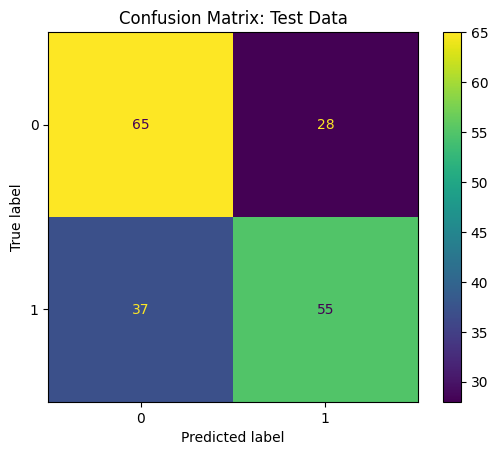

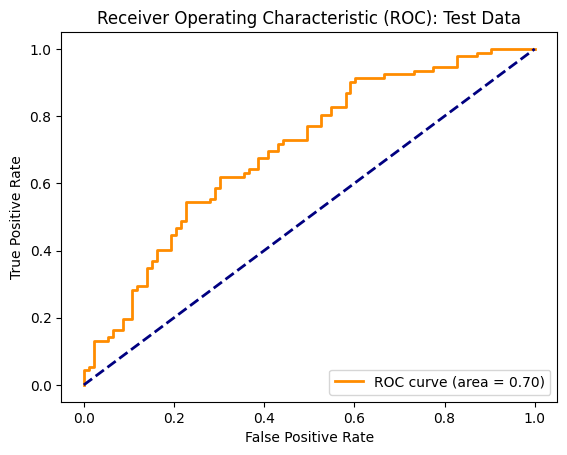

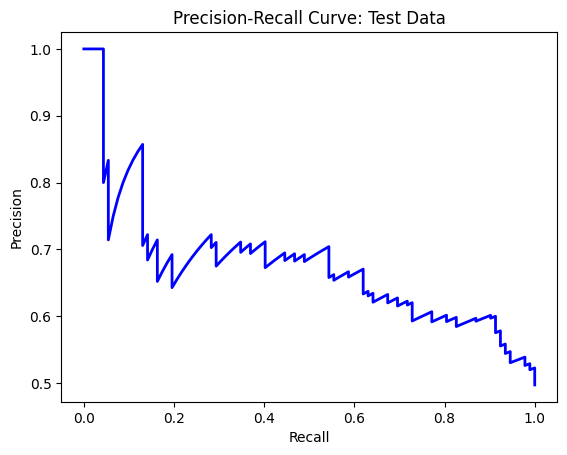

F1-Score: 0.6285714285714286


In [90]:
evaluate_model(test_y, test_y_pred_logistic, test_y_pred_prob_logistic, title = "Test Data")

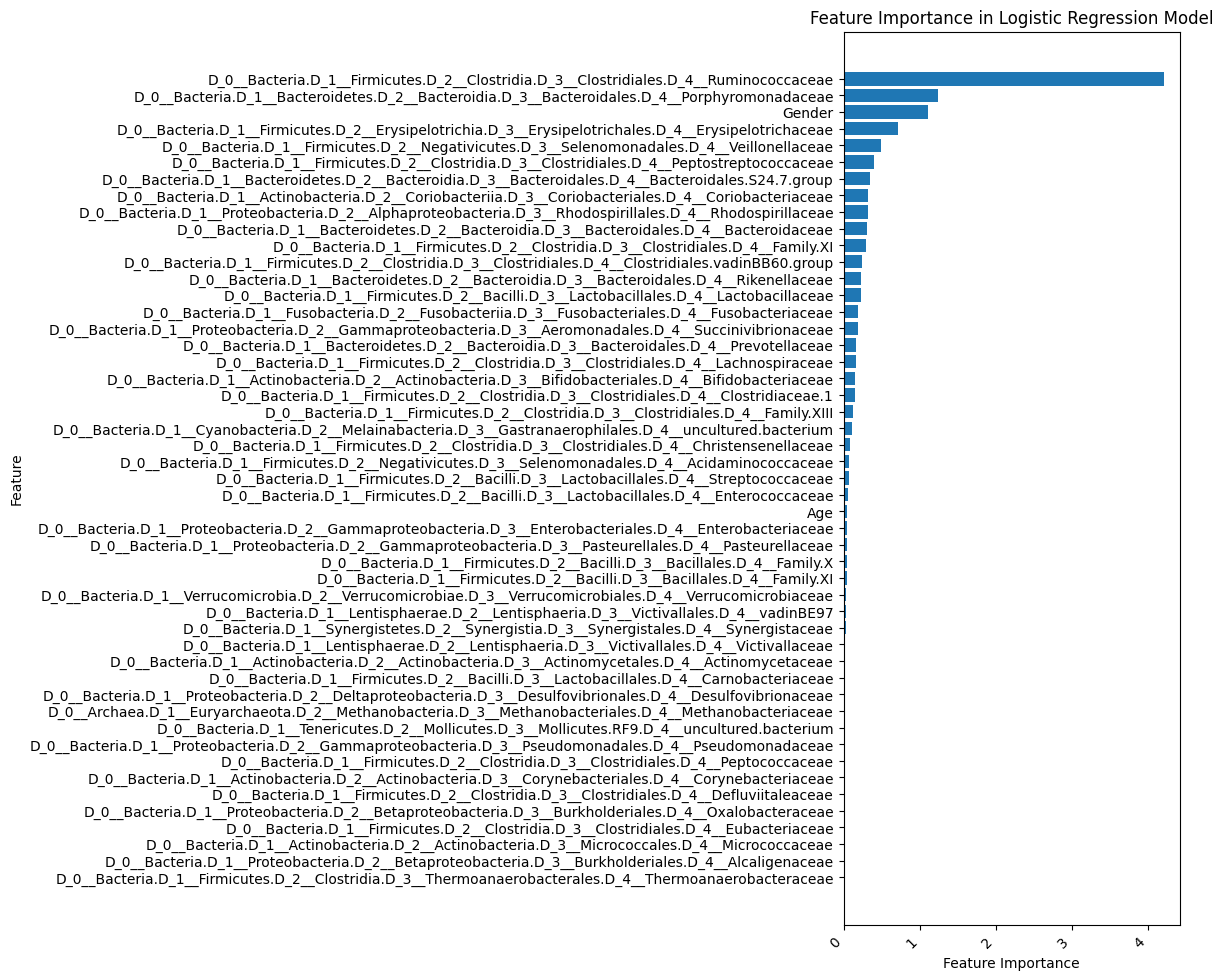

In [91]:
# Get the feature importances (coefficients)
importances = logistic_model.coef_[0]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': np.abs(importances)  # Taking the absolute value of the coefficients
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [92]:
# Define Objective Function
def objective_lg(trial):
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = 'l2' if solver == 'liblinear' else trial.suggest_categorical('penalty', ['l1', 'l2'])
    threshold = trial.suggest_float('threshold', 0.1, 0.9)

    # Create and train the model
    model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=10000, random_state=42)
    model.fit(train_x, train_y)

    # Evaluate the model with the adjusted threshold
    test_y_pred_prob = model.predict_proba(test_x)[:, 1]
    test_y_pred = (test_y_pred_prob > threshold).astype(int)
    accuracy = accuracy_score(test_y, test_y_pred)
    
    return accuracy

In [93]:
# Hyperparameter Tuning
study_lg = optuna.create_study(direction='maximize')
study_lg.optimize(objective_lg, n_trials=70)

[I 2024-08-07 17:54:31,203] A new study created in memory with name: no-name-09739c0e-426b-43f5-b332-4146097d58ec
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_69436/2972516686.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-08-07 17:54:32,233] Trial 0 finished with value: 0.6162162162162163 and parameters: {'C': 1.7455100454930892, 'solver': 'saga', 'penalty': 'l1', 'threshold': 0.30480333818685135}. Best is trial 0 with value: 0.6162162162162163.
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_69436/2972516686.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_logunifor

In [171]:
study_lg.best_params

{'C': 42.0845842861616,
 'solver': 'liblinear',
 'threshold': 0.36269686871976087}

In [94]:
# Train the final model with the best hyperparameters
lg_tuned = LogisticRegression(
    C=study_lg.best_params['C'],
    solver=study_lg.best_params['solver'],
    penalty='l2' if study_lg.best_params['solver'] == 'liblinear' else study_lg.best_params['penalty'],
    max_iter=10000,
    random_state=42
)
lg_tuned.fit(train_x, train_y)



LogisticRegression(C=42.0845842861616, max_iter=10000, random_state=42,
                   solver='liblinear')

In [95]:
# Evaluate the final model
test_y_pred_prob_lg_tuned = lg_tuned.predict_proba(test_x)[:, 1]
test_y_pred_lg_tuned = (test_y_pred_prob_lg_tuned > study_lg.best_params['threshold']).astype(int)

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        93
           1       0.66      0.84      0.74        92

    accuracy                           0.70       185
   macro avg       0.72      0.70      0.70       185
weighted avg       0.72      0.70      0.70       185



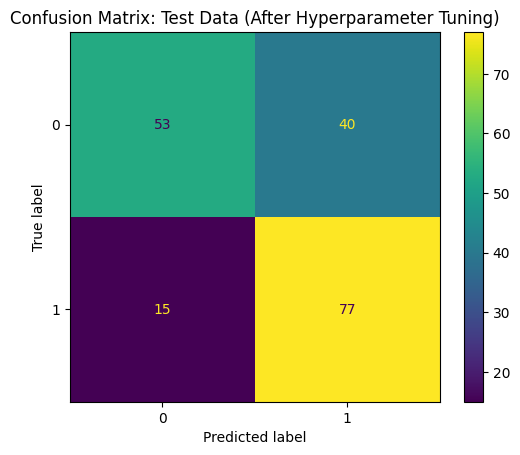

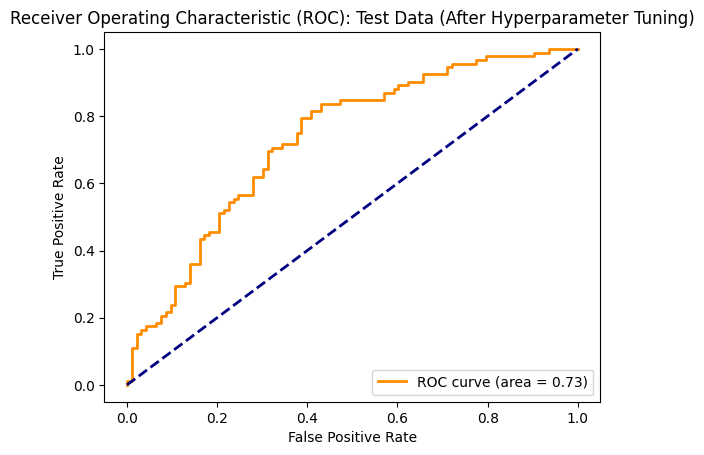

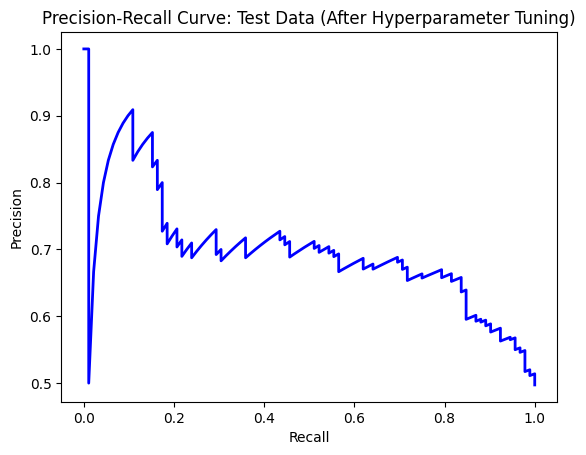

F1-Score: 0.7368421052631579


In [96]:

evaluate_model(test_y, test_y_pred_lg_tuned, test_y_pred_prob_lg_tuned, title = "Test Data (After Hyperparameter Tuning)")

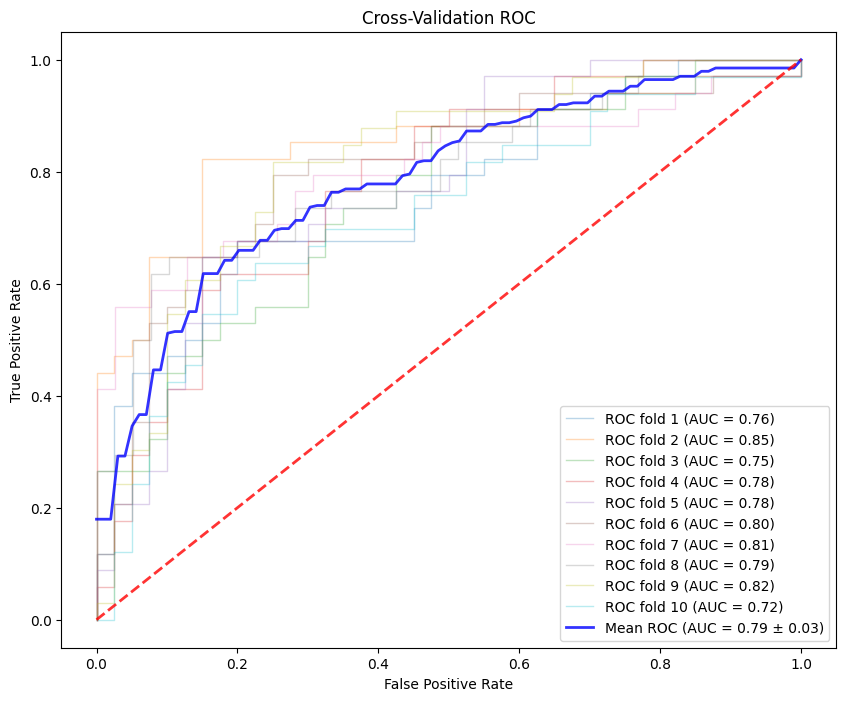

Cross-validation AUC Scores: [0.7595588235294117, 0.8463235294117647, 0.7536764705882354, 0.7786764705882352, 0.7794117647058824, 0.8022058823529412, 0.8054298642533937, 0.7911010558069382, 0.8151515151515152, 0.7234848484848485]
Mean Cross-validation AUC: 0.7861


In [97]:
CV_ROC(lg_tuned, train_x, train_y)

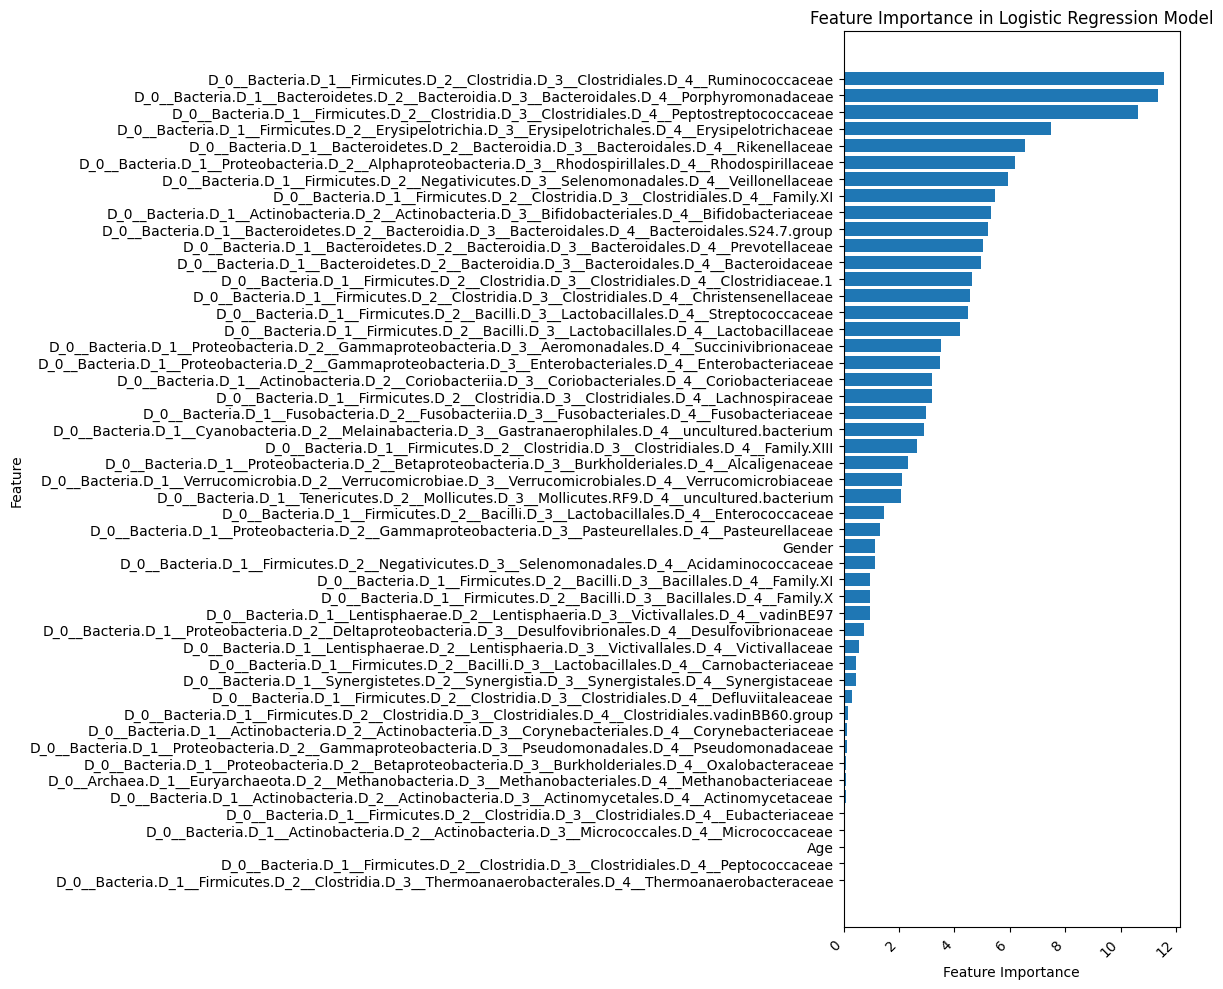

In [172]:
# Get the feature importances (coefficients)
importances = lg_tuned.coef_[0]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': np.abs(importances)  # Taking the absolute value of the coefficients
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances with adjusted figure size and label rotation
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.gca().invert_yaxis()

# Adjusting the layout and rotation of x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [173]:
feature_importances_df.head(10)

Feature  \
30                    D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Ruminococcaceae   
10             D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Porphyromonadaceae   
29              D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Peptostreptococcaceae   
32     D_0__Bacteria.D_1__Firmicutes.D_2__Erysipelotrichia.D_3__Erysipelotrichales.D_4__Erysipelotrichaceae   
12                  D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Rikenellaceae   
38  D_0__Bacteria.D_1__Proteobacteria.D_2__Alphaproteobacteria.D_3__Rhodospirillales.D_4__Rhodospirillaceae   
34               D_0__Bacteria.D_1__Firmicutes.D_2__Negativicutes.D_3__Selenomonadales.D_4__Veillonellaceae   
25                          D_0__Bacteria.D_1__Firmicutes.D_2__Clostridia.D_3__Clostridiales.D_4__Family.XI   
4      D_0__Bacteria.D_1__Actinobacteria.D_2__Actinobacteria.D_3__Bifidobacteriales.D_4__Bifidobacteriaceae   
9       D_0__Bacteria.D_1__Bacteroidetes.D_2__Bacteroidia.D_3__Bacteroidales.D_4__Bacteroidales.S24.7.group   

    Importance  
30   11.568850  
10   11.347577  
29   10.626162  
32    7.490681  
12    6.551906  
38    6.184682  
34    5.924358  
25    5.477249  
4     5.335573  
9     5.232208

ENSEMBLE MODEL of Tuned Random Forest and LightGBM

In [100]:
from optuna.samplers import TPESampler
from sklearn.ensemble import StackingClassifier

In [101]:
# Define the StackingClassifier with the tuned meta-model
base_models_tuned = [
    ('rf', rf_tuned),
    ('lgbm', model_lgb_tuned)
]

In [102]:
meta_model = LogisticRegression()

In [103]:
stacking_clf = StackingClassifier(estimators=base_models_tuned, final_estimator=meta_model, cv=5)

In [104]:
stacking_clf.fit(train_x, train_y)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=8,
                                                       min_samples_leaf=9,
                                                       min_samples_split=39,
                                                       n_estimators=281,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.5346813577961307,
                                               bagging_freq=7,
                                               feature_fraction=0.8656735134793141,
                                               lambda_l1=1.3608422295315864e-05,
                                               lambda_l2=0.0022838633454445078,
                                               learning_rate=0.02622095648651683,
                                               max_depth=50,
                                               min_data_in_leaf=40,
                                               n_estimators=1000,
                                               num_leaves=200,
                                               threshold=0.5519175959483338))],
                   final_estimator=LogisticRegression())

In [106]:
# Make predictions on the test set
test_y_pred_prob_ensemble = stacking_clf.predict_proba(test_x)[:, 1]
test_y_pred_ensemble = (test_y_pred_prob_ensemble > 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        93
           1       0.76      0.71      0.73        92

    accuracy                           0.74       185
   macro avg       0.74      0.74      0.74       185
weighted avg       0.74      0.74      0.74       185



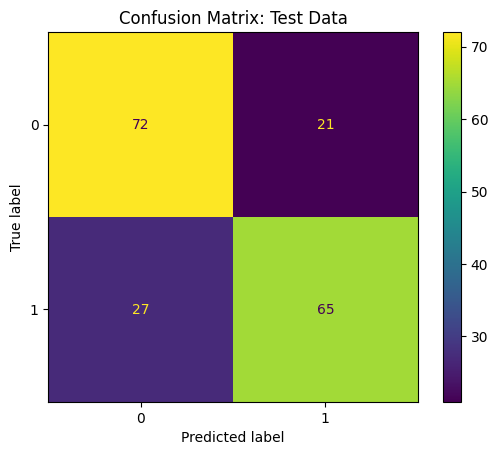

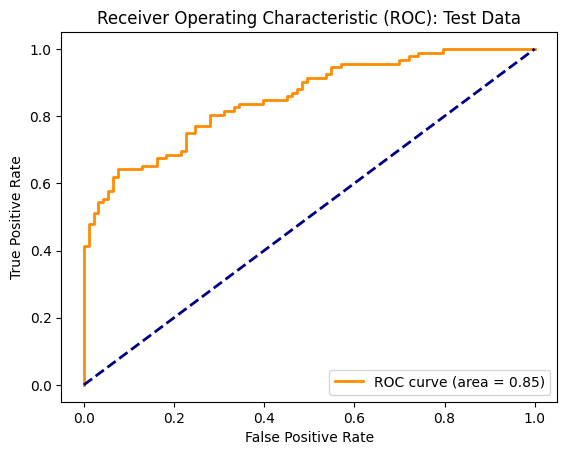

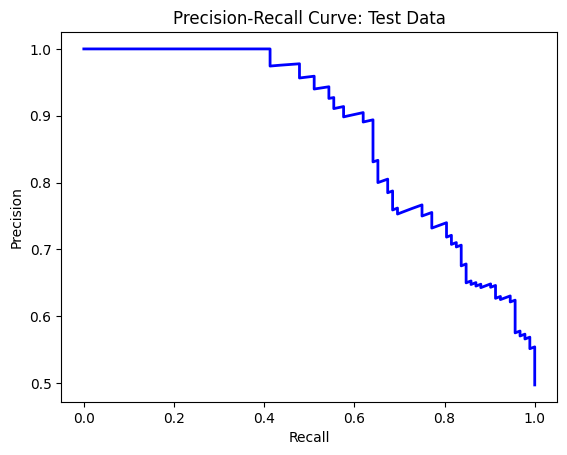

F1-Score: 0.7303370786516854


In [107]:
evaluate_model(test_y, test_y_pred_ensemble, test_y_pred_prob_ensemble, title = "Test Data")

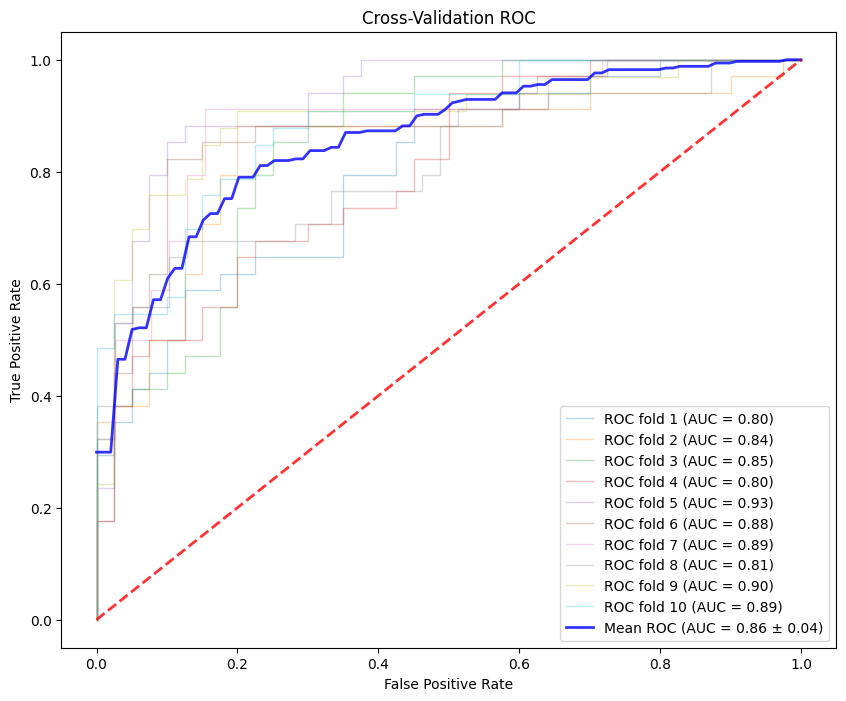

Cross-validation AUC Scores: [0.7963235294117648, 0.836764705882353, 0.8522058823529413, 0.8007352941176471, 0.9279411764705883, 0.8808823529411764, 0.88763197586727, 0.8122171945701357, 0.8954545454545455, 0.8856060606060606]
Mean Cross-validation AUC: 0.8580


In [108]:
CV_ROC(stacking_clf, train_x, train_y)

Hyperparameter Tuning of Ensemble Model

In [109]:
#Hyperparameter tuning of Ensemble model:

# Define the objective function for tuning the meta-model
def objective_meta(trial):
    # Define hyperparameters for Logistic Regression
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = 'l2' if solver == 'liblinear' else trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    threshold = trial.suggest_float('threshold', 0.1, 0.9)


    meta_model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=max_iter, random_state=42)

    stacking_clf = StackingClassifier(estimators=base_models_tuned, final_estimator=meta_model, cv=5)

    # Train the stacking classifier
    stacking_clf.fit(train_x, train_y)
    
    test_y_pred_prob = stacking_clf.predict_proba(test_x)[:, 1]
    test_y_pred = (test_y_pred_prob > threshold).astype(int)
    
    # Calculate the accuracy
    accuracy = accuracy_score(test_y, test_y_pred)
    
    return accuracy

In [110]:
study_meta = optuna.create_study(direction='maximize', sampler=TPESampler())
study_meta.optimize(objective_meta, n_trials=70)

[I 2024-08-07 20:50:21,305] A new study created in memory with name: no-name-a494792f-1b87-42a0-8a20-4d33d8490a68
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_69436/2303748707.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-08-07 20:50:25,735] Trial 0 finished with value: 0.7675675675675676 and parameters: {'C': 0.5387932058859055, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 509, 'threshold': 0.4019302886384978}. Best is trial 0 with value: 0.7675675675675676.
/var/folders/lq/34n0v0691xddfy7xs_p1x7940000gn/T/ipykernel_69436/2303748707.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.s

In [111]:
# Get the best parameters for the meta-model
best_meta_params = study_meta.best_params
print("Best Meta-Model params:", best_meta_params)

Best Meta-Model params: {'C': 1.0052460724001673, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 571, 'threshold': 0.4231871077870518}


In [112]:
del best_meta_params['threshold']

In [113]:
# Define the tuned meta-model
meta_model_tuned = LogisticRegression(**best_meta_params)

# Create the stacking classifier with the tuned meta-model
stacking_clf_tuned = StackingClassifier(estimators=base_models_tuned, final_estimator=meta_model_tuned)

In [114]:
# Train the stacking classifier with tuned meta-model
stacking_clf_tuned.fit(train_x, train_y)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=8,
                                                       min_samples_leaf=9,
                                                       min_samples_split=39,
                                                       n_estimators=281,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(bagging_fraction=0.5346813577961307,
                                               bagging_freq=7,
                                               feature_fraction=0.8656735134793141,
                                               lambda_l1=1.3608422295315864e-05,
                                               lambda_l2=0.0022838633454445078,
                                               learning_rate=0.02622095648651683,
                                               max_depth=50,
                                               min_data_in_leaf=40,
                                               n_estimators=1000,
                                               num_leaves=200,
                                               threshold=0.5519175959483338))],
                   final_estimator=LogisticRegression(C=1.0052460724001673,
                                                      max_iter=571,
                                                      penalty='l1',
                                                      solver='saga'))

In [115]:
# Make predictions on the test set
test_y_pred_prob_ensemble_tuned = stacking_clf_tuned.predict_proba(test_x)[:, 1]
test_y_pred_ensemble_tuned = (test_y_pred_prob_ensemble_tuned > 0.4231871077870518).astype(int)

              precision    recall  f1-score   support

           0       0.78      0.77      0.78        93
           1       0.77      0.78      0.78        92

    accuracy                           0.78       185
   macro avg       0.78      0.78      0.78       185
weighted avg       0.78      0.78      0.78       185



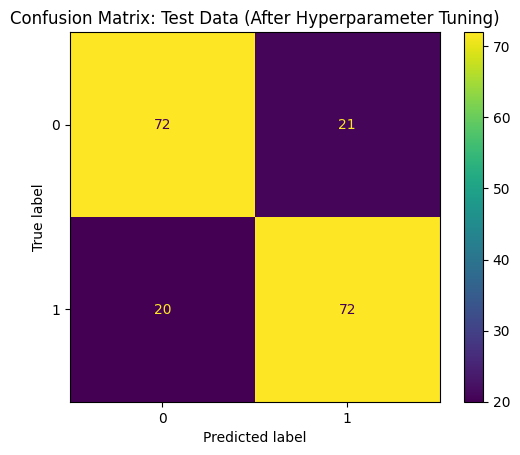

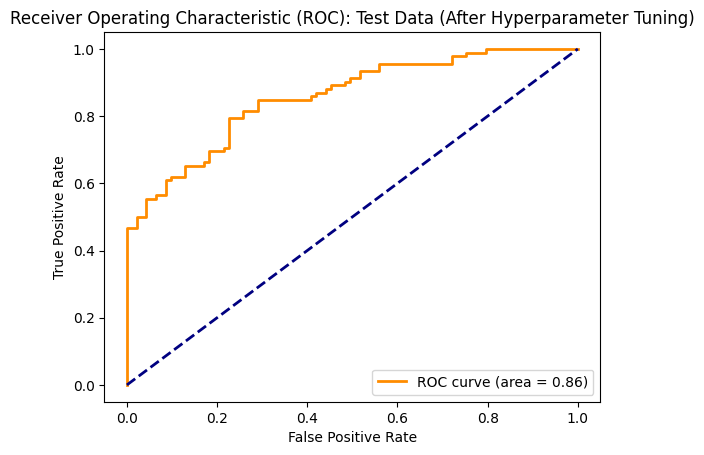

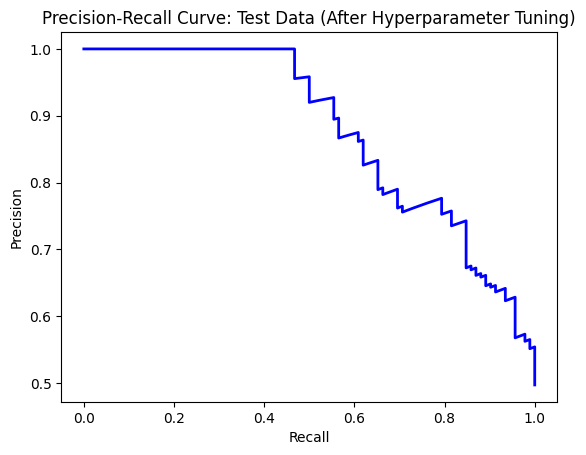

F1-Score: 0.7783783783783784


In [116]:
evaluate_model(test_y, test_y_pred_ensemble_tuned, test_y_pred_prob_ensemble_tuned, title = "Test Data (After Hyperparameter Tuning)")

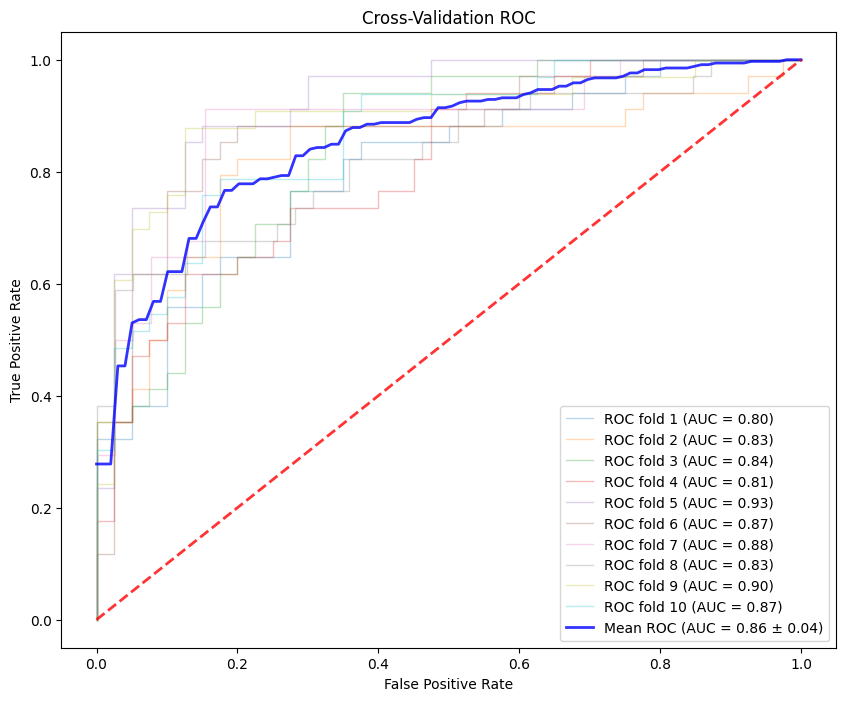

Cross-validation AUC Scores: [0.8044117647058824, 0.825735294117647, 0.8426470588235294, 0.8088235294117647, 0.9257352941176471, 0.8720588235294118, 0.8815987933634992, 0.8265460030165913, 0.8984848484848486, 0.8651515151515151]
Mean Cross-validation AUC: 0.8555


In [117]:
CV_ROC(stacking_clf_tuned, train_x, train_y)